/home/ubuntu/anaconda3/envs/p36env/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


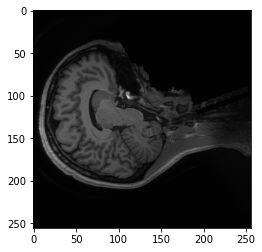

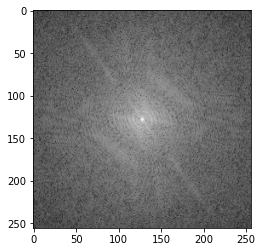

In [10]:
import sys
sys.path.insert(0,'../../common/')
import bart

import subsample
import pathlib
import h5py
import numpy as np
from common import utils
from matplotlib import pyplot as plt
import torch
try:
    import nibabel as nib
except:
    ! pip install nibabel 
    import nibabel as nib

from data import transforms, mri_data

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])

def data_transform(kspace, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, _ = transforms.apply_mask(kspace, mask_func)
    return masked_kspace
'''
dataset = mri_data.SliceData(
    root=pathlib.Path('dataset/'),
    transform=data_transform,
    challenge='singlecoil'
)
'''
img = nib.load('/home/ubuntu/Downloads/dataset/singlecoil_val.nii')
img_data = img.get_data()
img_data_arr = np.asarray(img_data)
test_1=img_data_arr[:,:,88+9]
plt.imshow(test_1,cmap='gray')
plt.figure()
data = test_1.astype(np.float32)
img_torch = torch.from_numpy(data)
fft_img_torch = torch.fft.fft2(img_torch,norm="ortho")
fft_img_torch = torch.fft.fftshift(fft_img_torch) 
plt.imshow(20*np.log(torch.abs(fft_img_torch)),cmap='gray')



In [11]:
img_data_arr = img_data_arr.astype(np.float32)
img_data_torch = torch.from_numpy(img_data_arr)

In [12]:
img_data_torch.shape

torch.Size([256, 256, 176])

In [13]:
kspace = np.zeros(img_data_torch.shape,dtype='complex')
kspace = torch.from_numpy(kspace)
for i in range(img_data_torch.shape[2]):
    fft_img = torch.fft.fft2(img_data_torch[:,:,i],norm="ortho")
    kspace[:,:,i] = torch.fft.fftshift(fft_img ) 

mask_func = subsample.RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[2, 4])    
masked_kspace, _ = transforms.apply_mask(kspace, mask_func)
masked_kspace = masked_kspace.unsqueeze(0)
masked_kspace = masked_kspace.permute(1, 2, 0, 3).unsqueeze(0)
masked_kspace = utils.tensor_to_complex_np(masked_kspace)

    # Estimate sensitivity maps
sens_maps = bart.bart(1, f'ecalib -d0 -m1', masked_kspace)

    # Use Total Variation Minimization to reconstruct the image
pred = bart.bart(1, f'pics -d0 -S -R T:7:0:{0.01} -i {100}', masked_kspace, sens_maps)
pred = torch.from_numpy(np.abs(pred[0]))

/home/ubuntu/anaconda3/envs/p36env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


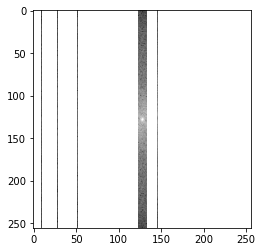

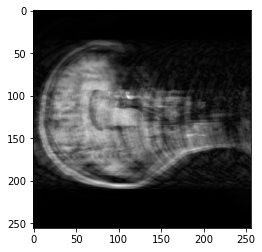

In [15]:
kspace = np.zeros(img_data_torch.shape,dtype='complex')
kspace = torch.from_numpy(kspace)
for i in range(img_data_torch.shape[2]):
    fft_img = torch.fft.fft2(img_data_torch[:,:,i],norm="ortho")
    kspace[:,:,i] = torch.fft.fftshift(fft_img ) 

mask_func = subsample.RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[2, 4])    
masked_kspace, _ = transforms.apply_mask(kspace, mask_func)
masked_kspace_97 = masked_kspace[:,:,88+9]
plt.imshow(20*np.log(torch.abs(masked_kspace_97)),cmap='gray')
plt.figure()
slice_97 = torch.fft.ifft2(torch.fft.ifftshift(masked_kspace_97))
plt.imshow(torch.abs(slice_97),cmap='gray')

masked_kspace_97 = masked_kspace_97.detach().cpu().numpy()
sens_maps = bart.bart(1, f'ecalib -d0 -m1', masked_kspace_97)
pred = bart.bart(1, f'pics -d0 -S -R T:7:0:{0.01} -i {100}', masked_kspace_97, sens_maps)

slice_97 = slice_97.detach().cpu().numpy()

#pred = torch.from_numpy(np.abs(pred[0]))

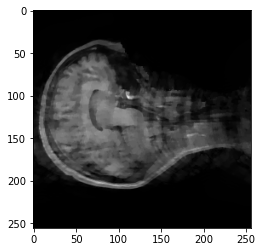

In [16]:
#pred=transforms.center_crop(np.fft.ifftshift(pred), (smallest_height, smallest_width))
pred = np.fft.ifftshift(pred)
plt.imshow(np.abs(pred),cmap='gray')

In [17]:
from skimage.measure import compare_ssim
from skimage.metrics import peak_signal_noise_ratio

(score, diff) = compare_ssim(np.abs(slice_97), test_1, full=True)
psnr1 = peak_signal_noise_ratio(test_1,np.abs(slice_97) ,data_range=test_1.max()-test_1.min())
print(f'Compressed Sensed Image: SSIM = {score:.3f}, PSNR = {psnr1:.3f}')

(score, diff) = compare_ssim(np.abs(pred), test_1, full=True)
psnr1 = peak_signal_noise_ratio(test_1,np.abs(pred) ,data_range=test_1.max()-test_1.min())
print(f'Reconstructed Image: SSIM = {score:.3f}, PSNR = {psnr1:.3f}')

Compressed Sensed Image: SSIM = 0.268, PSNR = 16.969
Reconstructed Image: SSIM = 0.348, PSNR = 28.971


/home/ubuntu/anaconda3/envs/p36env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/envs/p36env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [23]:
import cv2 

cv2.imwrite('cs.jpeg',(slice_97))

TypeError: img data type = 15 is not supported